---
# 0. SETUP

## Modules

In [21]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
from matplotlib import colors,lines,ticker
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO, Phylo
import seaborn as sns
import subprocess
import geopy
from geopy import distance
import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.stats.multitest as smmt
import math
from skbio.stats import distance as skbio_dist
from functions import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sklearn

## Paths

In [22]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [23]:
# Manual Override
results_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"
print(results_dir)

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/


In [24]:
iqtree_dir    = os.path.join(results_dir, "iqtree/{}/{}/{}/filter{}/".format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA))
variant_qc_dir    = os.path.join(results_dir, "variant_qc/{}/{}/".format(READS_ORIGIN, LOCUS_NAME))

metadata_path = iqtree_dir    + "filter-taxa/metadata.tsv"
variant_qc_path = variant_qc_dir    + "variant_qc.txt"

# ------------------------------------------
# Trees
divtree_path  = iqtree_dir    + "filter-taxa/iqtree.treefile"

if PRUNE == "prune":
    full_divtree_path = divtree_path.replace("prune","full")
    full_metadata_path = metadata_path.replace("prune","full")
else:
    full_divtree_path = divtree_path
    full_metadata_path = metadata_path

# ------------------------------------------
# Output
out_dir = iqtree_dir.replace("iqtree", "iqtree_stats")
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [25]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
ALPHA = 0.05

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

---
# 1. IMPORT

## Variant QC

In [26]:
variant_qc_df = pd.read_csv(variant_qc_path, sep=' ', index_col = 0)
variant_qc_df.fillna(NO_DATA_CHAR, inplace=True)
display(variant_qc_df)

,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio
sample,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,1.854,216,121,51,2.37255,1,0.019608,242,216,26,0.107438
GCA_009669545.1_ASM966954v1_genomic,1.935,246,134,60,2.23333,0,0.000000,271,246,25,0.092251
GCA_009669555.1_ASM966955v1_genomic,2.119,241,133,58,2.29310,0,0.000000,258,241,17,0.065891
GCA_009669565.1_ASM966956v1_genomic,2.000,247,135,60,2.25000,0,0.000000,265,247,18,0.067924
GCA_009669605.1_ASM966960v1_genomic,2.012,239,132,58,2.27586,0,0.000000,260,239,21,0.080769
...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,1.917,96,48,28,1.71429,3,0.107143,120,96,24,0.200000
SAMEA7313246_49,1.813,171,74,45,1.64444,17,0.377778,260,171,89,0.342308
SAMEA6651390,2.378,138,72,40,1.80000,1,0.025000,218,138,80,0.366972


## Metadata

In [27]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

full_metadata_df = pd.read_csv(full_metadata_path, sep='\t', index_col = 0)
full_metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Merge

In [28]:
for rec in variant_qc_df.iterrows():
    sample = rec[0]
    if sample in metadata_df.index:
        for column in variant_qc_df.columns:
            metadata_df.at[sample, column] = variant_qc_df[column][sample]                
                
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Trees

In [29]:
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

# Rename internal nodes      
node_i = 0
for c in divtree.find_clades():
    if not c.name or "NODE" in c.name:
        c.name = "NODE{}".format(node_i)
        node_i += 1

# Add external branch length
for t in divtree.get_terminals():
    sample = t.name
    metadata_df.at[sample, "external_branch_length"] = t.branch_length
    

    
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

#Phylo.draw(divtree, label_func = lambda x: metadata_df["external_branch_length"][x.name] if x.is_terminal() else '')

## Colors

In [30]:
## Manual
colors_dict = {'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4'}

population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)
population_list.reverse()

# Initialize columns
metadata_df["population_color"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["population"]       = [NO_DATA_CHAR] * len(metadata_df)

for t in divtree.get_terminals():       
    # Assign population
    branch_minor = full_metadata_df["branch_minor"][t.name]
    branch_major = full_metadata_df["branch_major"][t.name]
    population = branch_major
    if branch_minor == "0.ANT4":
        population = branch_minor
    metadata_df.at[t.name, "population"] = population        
    
    # Assign color
    population_color = colors_dict[population]
    metadata_df.at[t.name, "population_color"] = population_color
    
display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.607716 38.7251776),0.000073,NA,0.000006,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.004600e-06
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.7957942 47.6222451),0.000073,NA,0.000010,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.120100e-06
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000054,NA,0.000012,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0.000000e+00
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.356000e-07
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012,2,247,135,60,2.25,0,0,265,247,18,0.0679245,4.711000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.7957942 47.6222451),0.000075,NA,0.000022,1.917,96,48,28,1.71429,3,0.107143,120,96,24,0.2,1.202300e-06
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.1099 54.24556),0.000060,NA,0.000007,1.813,171,74,45,1.64444,17,0.377778,260,171,89,0.342308,5.131000e-07
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953400167952 54.82269205),0.000060,NA,0.000006,2.378,138,72,40,1.8,1,0.025,218,138,80,0.366972,2.360000e-08


## Sampling Age Range

In [50]:
out_path = os.path.join(out_dir, "population_time_frame.tsv")
print(out_path)
time_frame_dict = {}

with open(out_path, "w") as outfile:
    header = "{}\t{}\t{}\t{}\t{}".format("population", "samples", "min_date", "max_date", "range_date")
    print(header)
    outfile.write(header + "\n")
    
    for population in population_list:
        df = metadata_df[metadata_df["population"] == population]
        
        drop_sample = "SAMEA104488961"
        if drop_sample in df.index:
            df.drop(drop_sample, inplace=True)    
        
        comment = df["biosample_comment"][0]
        samples = len(df)
        min_date = 2021
        max_date = -999999
        for sample in df.index:
            date_mean = df["date_mean"][sample]
            if "Modern" in comment:
                sample_min = date_mean
                sample_max = date_mean
            if "Ancient" in comment:
                date_err = df["date_err"][sample]
                sample_min = date_mean - date_err
                sample_max = date_mean + date_err
            if sample_min <= min_date:
                min_date = int(sample_min)
            if sample_max >= max_date:
                max_date = int(sample_max)
        range_date = max_date - min_date
        time_frame_dict[population] = range_date
        line = "{}\t{}\t{}\t{}\t{}".format(population, samples, min_date, max_date, range_date)
        print(line) 
        outfile.write(line + "\n")


/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/iqtree_stats/all/chromosome/full/filter5/population_time_frame.tsv
population	samples	min_date	max_date	range_date
1.ORI	117	1924	2016	92
1.IN	39	1954	2008	54
1.ANT	4	1954	2004	50
1.PRE	40	1270	1800	530
2.MED	116	1912	2018	106
2.ANT	54	1924	2008	84
4.ANT	11	1977	2015	38
3.ANT	11	1961	2017	56
0.ANT4	12	214	880	666
0.ANT	103	1947	2019	72
0.PE	85	1958	2014	56
0.PRE	8	-2876	-1626	1250


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Convert Dataframe to Geopandas

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.60772 38.72518),0.000073,NA,0.000006,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.004600e-06
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.79579 47.62225),0.000073,NA,0.000010,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.120100e-06
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),0.000054,NA,0.000012,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0.000000e+00
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46335 42.48050),0.000055,NA,0.000012,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.356000e-07
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),0.000055,NA,0.000012,2,247,135,60,2.25,0,0,265,247,18,0.0679245,4.711000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.79579 47.62225),0.000075,NA,0.000022,1.917,96,48,28,1.71429,3,0.107143,120,96,24,0.2,1.202300e-06
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.10990 54.24556),0.000060,NA,0.000007,1.813,171,74,45,1.64444,17,0.377778,260,171,89,0.342308,5.131000e-07
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953 54.82269),0.000060,NA,0.000006,2.378,138,72,40,1.8,1,0.025,218,138,80,0.366972,2.360000e-08


<GeoAxesSubplot:>

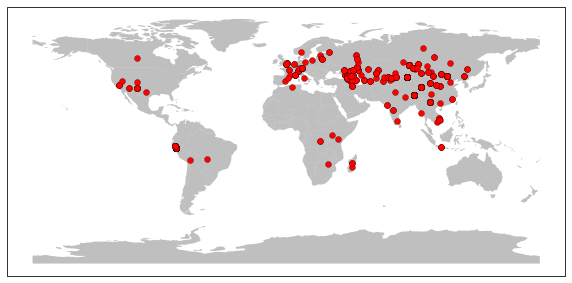

In [32]:
size_by_pop   = {}
size_by_coord  = {}
geometry = []

# Create geometry size dict
for rec in metadata_df.iterrows():
    sample = rec[0]
    population = rec[1]["population"]
    
    # Store the province, unless it's missing, then use country
    geo_name = rec[1]["province"]
    lat = rec[1]["province_lat"]
    lon = rec[1]["province_lon"]  
    
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
        lat = rec[1]["country_lat"]
        lon = rec[1]["country_lon"]   
        
    metadata_df.at[sample, "lat"] = lat
    metadata_df.at[sample, "lon"] = lon
    point = shapely.geometry.Point(lon,lat)  
    geometry.append(point)
    str_point = str(point.x) + "," + str(point.y)
        
    # Add Population to Dict
    if population not in size_by_pop:
        size_by_pop[population] = {}         
        
    # Add counter to the size_by_pop
    if geo_name not in size_by_pop[population]:
        size_by_pop[population][str_point] = 0
    size_by_pop[population][str_point] += 1
    
    # Add counter to size by coord
    if str_point not in size_by_coord:
        size_by_coord[str_point] = 0
    size_by_coord[str_point] += 1

metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)
display(metadata_gdf)

#print(size_by_pop["0.PRE"])
#print(size_by_coord)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", ec="black", lw=0.25)

## Calculate Root Distances

In [33]:
metadata_df["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["population_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)

population_mrca_dict = {}

# Get the MRCA for Each Population
for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    tips = list(df.index)
    mrca = divtree.common_ancestor(tips)
    population_mrca_dict[population] = mrca

for c in divtree.get_terminals():
    sample = c.name
    if sample not in metadata_df.index: continue
    population = metadata_df["population"][sample]    
    # Genetic Distance to Root
    root_dist = divtree.distance(divtree.root, c)
    # Genetic Distance to Population MRCA 
    mrca = population_mrca_dict[population]
    mrca_dist = divtree.distance(mrca, c)

    metadata_df.at[sample, "root_rtt_dist"] = float(root_dist)
    metadata_df.at[sample, "population_rtt_dist"] = float(mrca_dist)

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.60772 38.72518),7.31686e-05,NA,6.3815e-06,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.004600e-06
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.79579 47.62225),7.30501e-05,NA,9.6582e-06,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.120100e-06
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),5.41847e-05,NA,1.15566e-05,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0.000000e+00
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46335 42.48050),5.47035e-05,NA,1.20754e-05,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.356000e-07
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46335 42.48050),5.4939e-05,NA,1.23109e-05,2,247,135,60,2.25,0,0,265,247,18,0.0679245,4.711000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.79579 47.62225),7.54024e-05,NA,2.21397e-05,1.917,96,48,28,1.71429,3,0.107143,120,96,24,0.2,1.202300e-06
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.10990 54.24556),6.01348e-05,NA,6.8721e-06,1.813,171,74,45,1.64444,17,0.377778,260,171,89,0.342308,5.131000e-07
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953 54.82269),5.95981e-05,NA,6.3354e-06,2.378,138,72,40,1.8,1,0.025,218,138,80,0.366972,2.360000e-08


## Time Dependency of Rate Variation

1.ORI
1.IN
1.ANT
1.PRE
2.MED
2.ANT
4.ANT
3.ANT
0.ANT4
0.ANT
0.PE
0.PRE
y = 0.002x - 6.66e-07x² + 0.0019


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


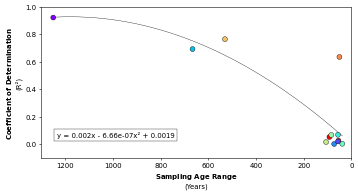

In [70]:
DPI = 50
FIGSIZE = [8,4]

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

x = []
y = []
c_list = []

for population in population_list:
    print(population)
    
    # Prep pop data frame
    df = metadata_df[metadata_df["population"] == population]
    
    drop_sample = "SAMEA104488961"
    if drop_sample in df.index:
        df.drop(drop_sample, inplace=True)    
        
    # Perform regression
    dates = list(df["date_mean"])
    dists = list(df["population_rtt_dist"])        
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dates, dists)
    r_squared = r_value * r_value
    
    color = df["population_color"][0]
    time_frame = time_frame_dict[population]


    x.append(time_frame)
    y.append(r_squared)
    c_list.append(color)

# Fit an exponential model
def func_exp(x, a, b, c):
    return a * x + b * x**2 + c
popt, _ = scipy.optimize.curve_fit(func_exp, x, y)

# summarize the parameter values
a, b, c = popt
op_1 = "+"
if b < 0: op_1 = "-"
op_2 = "+"
if c < 0: op_2 = "-"
formula = "y = {:.3f}x {} {:.2e}x² {} {:.4f}".format(a,op_1,abs(b),op_2,abs(c))
print(formula)
# Create points for the line
x_line = np.arange(min(x), max(x), 1)
y_line = func_exp(x_line, a, b, c)
  
ax.plot(x_line, y_line, ls="-", lw=0.5, c="black", zorder=1)
    
sns.scatterplot(
        ax=ax,
        x=x,
        y=y,  
        s=50,
        c = c_list, 
        ec = "black",
        zorder=2,
    )


ax.set_xlim(1300,0)
ax.set_ylim(-0.1,1)
ax.set_xlabel(r"$\bf{Sampling\ Age\ Range}$" + "\n(Years)")
ax.set_ylabel(r"$\bf{Coefficient\ of\ Determination}$" + "\n(R²)")

# Use the stats from bootstrapping!
ax.annotate(
    (formula),
    xy=(0.05, 0.15),
    xycoords="axes fraction",
    #size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

out_path = os.path.join(out_dir, "rtt_curve_fit")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# External Branch Lengths

In [ ]:
# ----------------
# CI of external branch lengths

data = list(metadata_df["external_branch_length"])
data_arr = np.array(data)
confidence = 90
tails = 1
peak, ci = calc_peak_ci(data=data, confidence=confidence, tails=tails)
branch_len_thresh = ci[1]
print(branch_len_thresh)

# -----------------------------
# Long Branch Lengths
long_branch_dict = {pop: {"total_branches" : 0, "long_branches" : 0, "perc": 0,} for pop in population_list}


for rec in metadata_df.iterrows():
    sample = rec[0]
    population = rec[1]["population"]
    length = rec[1]["external_branch_length"]
    long_branch_dict[population]["total_branches"] += 1
    if length >= branch_len_thresh:
        long_branch_dict[population]["long_branches"] += 1

for pop in long_branch_dict:
    long_branch_dict[pop]["perc"] = (long_branch_dict[pop]["long_branches"] / long_branch_dict[pop]["total_branches"]) * 100

df = pd.DataFrame.from_dict(long_branch_dict, orient="index")
df["population"] = df.index

FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
FIGSIZE=[12,6]
## All
fig, axes = plt.subplots(1,2,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.5)
ax = axes[0]
sns.histplot(
    ax=ax,
    data=metadata_df,
    x="external_branch_length",
    kde=True,
    bins=50,
    color="grey",
)

ax.axvline(branch_len_thresh, color="black", ls="--", label="Threshold\n{:.2e}".format(branch_len_thresh))
ax.axvline(0, color="black", ls="--")
ax.set_ylabel("Number of External Branches")
ax.set_xlabel("External Branch Length\n(Substitutions/Site)")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1e-5))
ax.legend(fontsize=FONTSIZE-2, edgecolor="black")

ax = axes[1]


sns.barplot(
    ax=ax,
    data=df,
    #x="perc",
    x="long_branches",
    y="population",
    palette=colors_dict,
    ec="black",
)

ax.set_ylabel("Population")
ax.set_xlabel("Number of External Branches\nLonger Than Threshold")

out_path = os.path.join(out_dir, "long_branches")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# Tree Shapes

In [ ]:
out_path = os.path.join(out_dir, "branch_lengths.tsv")
print(out_path)
dpi=200
figsize=[6,3]

with open(out_path, "w") as outfile:
    header = "{}\t{}\t{}\t{}\t{}\t{}".format("population","total_length", "mean_dist_to_root", "ratio", "internal_prop", "external_prop",)
    print(header)
    outfile.write(header + "\n")


    for population in population_list:
        #if population != "1.ORI": continue
        out_img  =os.path.join(out_dir, "branch_lengths_{}".format(population))
            
        # Extract subtree
        df = metadata_df[metadata_df["population"] == population]
        #if population == "0.ANT":
        #    df = metadata_df[(metadata_df["population"] == "0.ANT") | (metadata_df["population"] == "0.ANT4")]
        color = df["population_color"][0]
        tips = list(df.index)
        divtree_copy = copy.deepcopy(divtree)
        subtree = extract_subtree(
            tree=divtree_copy, 
            tips=tips, 
            df=metadata_df, 
            color=color)
        
        
        # Drop RT5
        for t in subtree.get_terminals():
            if t.name == "SAMEA104488961":
                subtree.prune("SAMEA104488961")
                df.drop("SAMEA104488961", inplace=True)
        subtree.ladderize(reverse=True)
        
        # Identify long branches
        tip_colors = []
        for c in subtree.find_clades():

            # Condition 1 : terminal and long branch
            if c.is_terminal():
                tip_color = color
                if c.branch_length >= branch_len_thresh:
                    # Condition 2: parent is not the root
                    c_path = [subtree.root] + subtree.get_path(c)
                    if len(c_path) > 2:
                        c.color = "#c4c4c4"
                        tip_color = "#c4c4c4"
                tip_colors.append(tip_color)
            
            # Condition 3: internal and all tips are long
            else:
                prune = True
                for c_term in c.get_terminals():
                    if c_term.branch_length < branch_len_thresh:
                        prune = False
                if prune:
                    c.color = "#c4c4c4"
             
            
        
        # Branch Length Stats
        internal_lengths = []
        external_lengths = []
        dist_to_root = []

        for c in subtree.find_clades():
            if c == subtree.root:
                c.branch_length = 0
                continue
            if c.is_terminal():
                external_lengths.append(c.branch_length)
            else:
                internal_lengths.append(c.branch_length)
            dist_to_root.append(subtree.distance(c))
            
        mean_dist_to_root = sum(dist_to_root) / len(dist_to_root)

        internal_length = sum(internal_lengths)
        external_length = sum(external_lengths)
        
        total_length = internal_length + external_length
        internal_prop = round(internal_length / total_length, 2)
        external_prop = round(external_length / total_length, 2)
        ratio = round(internal_length / external_length, 2)
        line = "{}\t{:.2e}\t{:.2e}\t{}\t{}\t{}".format(population, total_length,  mean_dist_to_root, ratio, internal_prop, external_prop)
        print(line)
        outfile.write(line + "\n")

        
        #-----------------------------
        # Plotting
        
        g = sns.JointGrid(       
                x=dist_to_root,
                space=0,
            )
        g.fig.suptitle(population, x=0.45, y=1.1, fontweight="bold")
        g.fig.set_figheight(figsize[1])
        g.fig.set_figwidth(figsize[0])
        g.fig.set_dpi(dpi)
        
        # Histogram
        ax=g.ax_marg_x
        sns.kdeplot(
            ax=ax,
            x=dist_to_root,
            fill=True,
            color=color,
            label=population,
            #cut=0,
            clip=[0,max(dist_to_root)]
        )
        
        
        # Tree
        ax = g.ax_joint
        plt.rcParams['lines.linewidth'] = 1         
        Phylo.draw(do_show=False,tree=subtree, label_func = lambda x: "", axes=ax, show_confidence=False,)
        
        ylim = ax.get_ylim()
        ylim_range = ylim[0] - ylim[1]
        xlim = ax.get_xlim()
        xlim_range = xlim[1] - xlim[0]
        xbuff = xlim_range * 0.01
        
        # Scatter     
        x = []
        y = []
        labels = []
        y_i = 1
        for t in subtree.get_terminals():
            x.append(subtree.distance(t))
            y.append(y_i)
            y_i += 1
            labels.append(round(metadata_df["date_mean"][t.name]))
        
        sns.scatterplot(ax=ax, x=x, y=y, s=10, c=tip_colors, edgecolor="black", zorder=2)
        
        # Critical Window
        #g.ax_joint.axvline(x=0, ls="--", color="black", lw=0.5)
        #g.ax_marg_x.axvline(x=0, ls="--", color="black", lw=0.5)
        
        #g.ax_joint.axvline(x=1e-5, ls="--", color="black", lw=0.5)
        #g.ax_marg_x.axvline(x=1e-5, ls="--", color="black", lw=0.5)
        
        #g.ax_joint.axvspan(xmin=0, xmax=1e-5, edgecolor="none", facecolor="#c4c4c4", alpha=0.25,)
        #g.ax_marg_x.axvspan(xmin=0, xmax=1e-5, edgecolor="none", facecolor="#c4c4c4", alpha=0.25)

        # General
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_xlabel("Distance to the MRCA\n(Substitutions/Site)")
        ax.set_ylim(ylim[0] + (ylim_range * 0.1), ylim[1] - (ylim_range * 0.1))
        ax.set_xlim(0 - (xlim_range* 0.1),)
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) 

        # Special
        if xlim_range < 1e-4:
            ax.set_xlim(-0.5e-5, 7e-5)
        else:
            ax.set_xlim(-0.5e-5, 2e-4)      
            
        #if population == "0.PRE" or population == "1.PRE" or population == "2.MED":
        #    ax.set_xlim(-0.5e-5, 2e-4) 

        plt.savefig(out_img + ".png", bbox_inches="tight")
        plt.savefig(out_img + ".svg", bbox_inches="tight")

---
# 0. Variant QC

In [ ]:
population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)
population_list.reverse()

population_colors = []

for population in population_list:
    population_colors.append(colors_dict[population])
    
ancient_df = df[df["biosample_comment"].str.contains("Ancient")]
modern_df = df[df["biosample_comment"].str.contains("Modern")]

variables = ["tstv", "ns_ss_ratio", "other_var_ratio"]
xlabels = ["TsTv Ratio", "NS / SS Ratio", "Other Variants Ratio"]
tails = [2, 2, 1]
confidence = 95

ylab="External Branch Length\n(Substitutions/Site)"
y="external_branch_length"
df = metadata_df[metadata_df[variables[0]] != NO_DATA_CHAR]
#df = df[(df["population"] == "0.ANT")]
#df = df[(df["external_branch_length"] >= 1e-5)]
# ---------------------------------------
# PLOT SETUP
FONTSIZE=14
plt.rc('font', size=FONTSIZE)

## Elbow

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

display(df[["strain", "tstv",  "ns_ss_ratio", "other_var_ratio", "external_branch_length"]].sort_values("other_var_ratio"))

#pd.set_option("display.max_rows", 10, "display.max_columns", None)


"""vals = range(50, 160, 5)

header = "{}\t{}\t{}".format("val", "long", "short")
long = []
short = []
print(header)
for val in vals:
    val = val /100
    sub_df = df[df[x] <= val]
    long_branches = len(sub_df[sub_df["external_branch_length"] >= 1e-5])
    short_branches = len(sub_df) - long_branches
    line = "{}\t{}\t{}".format(val, long_branches, short_branches)
    long.append(long_branches)
    short.append(short_branches)
    print(line)
    
sns.scatterplot(x=[v / 100 for v in vals], y=short, label="short")
sns.scatterplot(x=[v / 100 for v in vals], y=long, label="long")"""

## Branch Lengths

In [ ]:
long_branch_dict = {pop: {"total_branches" : 0, "long_branches" : 0, "perc": 0,} for pop in population_list}
threshold = 1e-5

for rec in metadata_df.iterrows():
    sample = rec[0]
    population = rec[1]["population"]
    length = rec[1]["external_branch_length"]
    long_branch_dict[population]["total_branches"] += 1
    if length >= threshold:
        long_branch_dict[population]["long_branches"] += 1

for pop in long_branch_dict:
    long_branch_dict[pop]["perc"] = (long_branch_dict[pop]["long_branches"] / long_branch_dict[pop]["total_branches"]) * 100

df = pd.DataFrame.from_dict(long_branch_dict, orient="index")
df["population"] = df.index

FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
FIGSIZE=[12,6]
## All
fig, axes = plt.subplots(1,2,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.5)
ax = axes[0]
sns.histplot(
    ax=ax,
    data=metadata_df,
    x="external_branch_length",
    kde=True,
    bins=50,
    color="grey",
)

ax.axvline(1e-5, color="black", ls="--", label="Threshold")
ax.set_ylabel("Number of External Branches")
ax.set_xlabel("External Branch Length\n(Substitutions/Site)")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1e-5))
ax.legend(fontsize=FONTSIZE-2, edgecolor="black")

ax = axes[1]


sns.barplot(
    ax=ax,
    data=df,
    #x="perc",
    x="long_branches",
    y="population",
    palette=colors_dict,
    ec="black",
)

"""y = 0
for rec in df.iterrows():
    #x = rec[1]["perc"]
    x = rec[1]["perc"]
    t = rec[1]["long_branches"]
    ax.text(x + 0.25, y + 0.1, str(round(t)), fontsize=FONTSIZE-4)
    y += 1"""

"""for y, x in enumerate(list(df["perc"])):
    print(y,x)
    ax.text(x + 0.5, y + .25, str(round(x)) + "%", fontsize=FONTSIZE-4)"""

ax.set_ylabel("Population")
ax.set_xlabel("Number of External Branches\nLonger Than Threshold")

out_path = os.path.join(out_dir, "long_branches")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## TsTv

In [ ]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
FIGSIZE=[18,6]
## All
fig, axes = plt.subplots(1,3,figsize=FIGSIZE, dpi=DPI)
    
df = metadata_df[metadata_df[variables[0]] != NO_DATA_CHAR]
outliers = []
ax_i = 0
for x, xlab, tail in zip(variables, xlabels, tails):
    ax = axes[ax_i]
    ax_i += 1
    samples = list(df.index)
    data_x = list(df[x])
    data_y = list(df[y])
    
    if tail == 2:
        adjust = (100 - confidence) / 2
        ci = [0 + adjust, 100 - adjust]
    elif tail == 1:
        ci = [0, confidence]
    x_ci = np.array(
        np.percentile(
            np.array(list(df[x])),
            ci,
            axis=0,
        )
    )
    print(x, ci, x_ci)


    """sns.histplot(
        ax=ax,
        data=df,
        x=data_x,
        kde=True,
        line_kws={"lw": 2},
        bins=10,
        kde_kws={"bw_adjust" : 0.7}
    )"""
    sns.kdeplot(
        ax=ax,
        data=df,
        x=data_x,
        fill=True,
        bw_adjust=0.7,
    )
        
    
    ax.set_xlabel(xlab)
    ax.set_ylabel("Number of Samples")
    #ax.axvline(x_ci[0], ls="--", color="black", lw=1)
    #ax.axvline(x_ci[1], ls="--", color="black", lw=1)
    
    for sample in df.index:
        val = df[x][sample]
        if x == "other_var_ratio" and "Ancient" in df["biosample_comment"][sample]:
            continue
        if x_ci[0] <= val <= x_ci[1]:
            outlier = False
        else:
            outlier = True
        if outlier and sample not in outliers:
            outliers.append(sample)
            print(df["population"][sample], df["strain"][sample], x, val)

metadata_df["variant_qc"] = ["pass"] * len(metadata_df)
for outlier in outliers:
    metadata_df.at[outlier, "variant_qc"] = "fail"
    
print("Outliers:", len(outliers))
#display(metadata_df)

### Plot

In [ ]:
for x, xlab in zip(variables, xlabels):
    confidence = 0.90
    samples = list(df.index)
    data_x = list(df[x])
    data_y = list(df[y])


    g = sns.JointGrid(       
                x=data_x,
                y=data_y,
                space=0,
            )


    # ------------------------------
    # Plot Bivariate KDE
    sns.kdeplot(
        ax=g.ax_joint,    
        x=data_x,
        y=data_y,    
        thresh=1-confidence,
        fill=True,
        color="grey",
    )

    # ------------------------------
    # Detect outliers
    outer_poly = g.ax_joint.collections[0]

    i = 0
    for px,py,ps in zip(data_x, data_y, samples):
        point = [px, py]
        outlier=1 # red

        for path in outer_poly.get_paths():        
            contained = path.contains_points([point])
            if contained:
                outlier=0 # blue
                break

        df.at[ps, x + "_outlier"] = outlier

    # ------------------------------
    # Plot Marginals
    g.plot_marginals(
        sns.kdeplot, 
        #bw_adjust=0.3,
        fill=True,
        color="grey",
    )

    # ------------------------------
    # Plot Scatter
    labels = ["Yes","No"]
    vals = [1,0]

    """for val,label in zip(vals, labels):
        sub_df = df[df[x + "_outlier"] == val]
        sns.scatterplot(
            ax=g.ax_joint,
            data=sub_df,
            x=x,
            y=y,
            s=30,
            ec = "black",      
            lw=1,
            label=label,
            alpha=0.9,
        )"""

    for population in population_list:
        pop_df = df[df["population"] == population]
        color = pop_df["population_color"][0]
        sns.scatterplot(
            ax=g.ax_joint,
            x=list(pop_df[x]),
            y=list(pop_df[y]),
            s=30,
            color=color,
            ec = "black",      
            #alpha=1.00,
            lw=1,
            zorder=2,   
            label=population,
        )

    g.ax_joint.set_xlabel(xlab)
    g.ax_joint.set_ylabel(ylab)
    g.ax_joint.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  

    #for ax in [g.ax_joint, g.ax_marg_y]:
    #    ax.axhline(1e-5, ls="--", c="black", lw=1)

    g.ax_joint.get_legend().remove()
    #g.fig.legend(title="Outlier", bbox_to_anchor=(1.3,0.8), edgecolor="black")
    g.fig.legend(title="Population", bbox_to_anchor=(1.3,0.8), edgecolor="black")


    out_path = os.path.join(out_dir, x)
    plt.savefig(out_path + ".png", bbox_inches="tight")
    plt.savefig(out_path + ".svg", bbox_inches="tight")

    for sample in df.index:
        metadata_df.at[sample, x + "_outlier"] = df[x + "_outlier"][sample]
    # Hmm
    metadata_df.at["Reference", x + "_outlier"] = 0

    out_path = os.path.join(out_dir, x + ".tsv")
    
    header = "{}\t{}\t{}\t{}".format("population", "samples", "outliers", "perc_outliers")
    with open(out_path, "w") as outfile:
        outfile.write(header + "\n")
        for population in population_list:
            pop_df = metadata_df[metadata_df["population"] == population]
            samples = len(pop_df)
            outliers = len(pop_df[pop_df[x + "_outlier"] == 1])
            perc_outliers = round((outliers/samples) * 100, 1)
            line = "{}\t{}\t{}\t{}".format(population, samples, outliers, perc_outliers)
            outfile.write(line + "\n")
    break

### Long Branch Percentage

In [ ]:
threshold = 1e-5
long_branches = 0
tstv_outlier = 0

tstv_min = 1.36
tstv_max = 3.9


for sample in metadata_df.index:
    branch_length = metadata_df["external_branch_length"][sample]
    tstv = metadata_df["tstv"][sample]
    
    if branch_length >= threshold:
        long_branches += 1
    
    if tstv == NO_DATA_CHAR: continue
    if tstv > tstv_max or tstv < tstv_min:
        tstv_outlier += 1
        
        
        
print(long_branches, tstv_outlier)
print(long_branches / len(metadata_df) * 100)

## TsTv Outliers

In [ ]:
# Final Values

tstv_min = 1.36
tstv_max = 3.9

out_path = os.path.join(out_dir, "tstv_outliers.tsv")

perc_outliers_dict = {}

with open(out_path, "w") as outfile:
    header = "{}\t{}\t{}\t{}".format("population", "samples", "outliers", "perc_outliers")
    print("|" + header.replace("\t", "|") + "|")
    outfile.write(header + "\n")

    for population in population_list:
        pop_df = df[df["population"] == population]
        samples = len(pop_df)
        outliers = len(pop_df[(pop_df["tstv"] <= tstv_min) | (pop_df["tstv"] >= tstv_max)])
        perc_outliers = round((outliers / samples) * 100)
        line = "{}\t{}\t{}\t{}".format(population, samples, outliers, perc_outliers)
        print("|" + line.replace("\t", "|") + "|")
        outfile.write(line + "\n")

        perc_outliers_dict[population] = perc_outliers


## Manual BEAST Rates

In [ ]:
# Bad placement in this notebook!!!

rates = {
 '1.ORI': 1.27e-07,
 '1.IN': 8.32e-08,
 '1.ANT': 5.84e-08,
 '1.PRE': 4.68e-08,
 '2.MED': 2.41e-07,
 '2.ANT': 8.18e-08,
 '4.ANT': 7.99e-08,
 '3.ANT': 6.25e-08,
 '0.ANT4': 3.63e-08,
 '0.ANT': 5.65e-08,
 '0.PE': 6.16e-07,
 '0.PRE': 5.56e-08}

x = list(perc_outliers_dict.values())
y = list(rates.values())

sns.scatterplot(x,y)

In [ ]:
"""# Final Values

tstv_min = 1.36
tstv_max = 3.9

header = "{}\t{}\t{}".format("population", "samples", "outliers", "perc_outliers")
print(header)


#print("tstv: ", tstv_min, tstv_max)
#print("ns_ss: ", ns_ss_min, ns_ss_max)
#print("other_var: ", other_var_min, other_var_max)
#print("external branch length:", 1e-05)

drop_samples = 0

out_path = os.path.join(out_dir, "variant_qc_fail.txt")

with open(out_path, "w") as outfile:
    header = "{}\t{}".format("BioSampleAccession", "BioSampleComment")
    outfile.write(header + "\n")
    for rec in metadata_df.iterrows():
        if rec[1]["ns_ss_ratio"] == NO_DATA_CHAR: continue        
        if "Modern" not in rec[1]["biosample_comment"]: continue

        sample = rec[0]

        ns_ss = rec[1]["ns_ss_ratio"]
        tstv = rec[1]["tstv"]
        other_var = rec[1]["other_var_ratio"]
        external_branch_length = rec[1]["external_branch_length"]
        if (
            sample in metadata_df.index
            and (
            tstv >= tstv_max
            or tstv <= tstv_min
            or ns_ss >= ns_ss_max
            or ns_ss <= ns_ss_min
            or other_var >= other_var_max
            or external_branch_length >= 1e-05)
        ):
            drop_samples += 1
            #metadata_df.drop(sample, inplace=True)
            acc = metadata_df["biosample_accession"][sample]
            comment = metadata_df["biosample_comment"][sample]
            comment += " QC Fail"
            outfile.write("{}\t{}\n".format(acc, comment))
        
print("Dropped", drop_samples, "out of", len(metadata_df_bak))
#display(metadata_df)"""

---
# 1. Mapping

In [ ]:
# ---------------------------------------
# PLOT SETUP

FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[18,6]

## All
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)

for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

# Sorry Antarctica
ax.set_ylim(-60,90)

world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.1,
) 

# Rescale the sizes for pie chart/inset axes
sizes = list(size_by_coord.values())
# Try to log values
#sizes = [math.log(s) for s in sizes]
# Convert to 2D array
sizes = np.reshape(np.array(sizes), (-1, 1))
rescale_max = 0.15
rescale_min = 0.025
sizes_rescale = sklearn.preprocessing.minmax_scale(sizes, feature_range=(rescale_min,rescale_max))
size_by_coord_rescale = {c:s[0] for c,s in zip(size_by_coord.keys(), sizes_rescale)}


i = 0
for coord in size_by_coord:
    # Get all samples from this coordinate
    coord_list = [float(c) for c in coord.split(",")]
    lon,lat = coord_list[0], coord_list[1]
    df = metadata_df[(metadata_df["lon"] == lon) & (metadata_df["lat"] == lat)]
    populations = set(df["population"])
    coord_colors = []
    sizes = []
    for pop in populations:
        num_samples = len(df[df["population"] == pop])
        color = colors_dict[pop]
        sizes.append(num_samples)    
        coord_colors.append(color)
        
    total_sizes = sum(sizes)
    ax_width = size_by_coord_rescale[coord]
    ax_width = size_by_coord_rescale[coord] * 5
    
   
    # Create an axis inset
    ax_sub=inset_axes(ax, width=ax_width, height=ax_width, loc=10, 
                       bbox_to_anchor=(lon, lat),
                       bbox_transform=ax.transData,
                       borderpad=0) 
    
    # Create pie chart
    wedges,texts= ax_sub.pie(
        sizes, 
        colors=coord_colors, 
        normalize=True,
        startangle=90,
        wedgeprops = {'linewidth': 0.25, 'edgecolor' : 'black', "alpha" : 0.75},
    )
    
    i += 1
    #if i > 20: break
    

# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()


population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=2, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population in populations]
population_labels = populations

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.2, 0.475),
           frameon=True,
            borderpad=0.5, 
            handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE / 2.25,
           title_fontsize=FONTSIZE / 1.5,
          )
population_legend.get_frame().set_linewidth(0.25)

    

# Size Legend
s = [ax.scatter(0,-9000, s=1, ec="black", c="white", lw=0.25),
     ax.scatter(0,-9000, s=10, ec="black", c="white", lw=0.25), 
    ax.scatter(0,-9000, s=100, ec="black", c="white", lw=0.25),     
    ]
sl = ["1", "10", "100"]
leg_size = fig.legend(s, sl, title="Genomes", loc="center",  borderpad=0.5, bbox_to_anchor=[0.3,0.45], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE / 1.5)
leg_size.get_frame().set_linewidth(0.25)


out_path = os.path.join(out_dir, "map_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")


## Individual map by population

In [ ]:
population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)

FONTSIZE=12
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[6,3]

for population in population_list:
    print(population)

    fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG}, figsize=FIGSIZE, dpi=DPI)

    # Sorry Antarctica
    ax.set_ylim(-60,90)
    color = colors_dict[population]

    world_polygons.plot(
        ax=ax, 
        zorder=1, 
        alpha=0.5, 
        color="grey",
        edgecolor="grey", 
        linewidth=0,
    ) 
    
    for coord in size_by_pop[population]:
        coord_list = [float(c) for c in coord.split(",")]
        lon,lat = coord_list[0], coord_list[1]
        gdf = metadata_gdf[(metadata_gdf["population"] == population) & (metadata_gdf["lon"] == lon) & (metadata_gdf["lat"] == lat)]
        num_samples = len(gdf)
        marker_scale = 20
        gdf.plot(
            ax=ax, 
            c=color, 
            ec="black", 
            lw=0.25, 
            markersize=num_samples * marker_scale,
            alpha=0.75,
        )
        
    out_path = os.path.join(out_dir, "map_{}".format(population))
    plt.savefig(out_path + ".png", bbox_inches="tight")
    plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 2. RTT (Root-To-Tip Regression)

## Calculate Population And Root Distances

In [ ]:
metadata_df["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["population_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)

population_mrca_dict = {}

# Get the MRCA for Each Population
for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    tips = list(df.index)
    mrca = divtree.common_ancestor(tips)
    population_mrca_dict[population] = mrca

for c in divtree.get_terminals():
    sample = c.name
    if sample not in metadata_df.index: continue
    population = metadata_df["population"][sample]    
    # Genetic Distance to Root
    root_dist = divtree.distance(divtree.root, c)
    # Genetic Distance to Population MRCA 
    mrca = population_mrca_dict[population]
    mrca_dist = divtree.distance(mrca, c)

    metadata_df.at[sample, "root_rtt_dist"] = float(root_dist)
    metadata_df.at[sample, "population_rtt_dist"] = float(mrca_dist)

display(metadata_df)

## Report Average RTT by Population

In [ ]:
rtt_all_list = list(metadata_df["root_rtt_dist"])
rtt_all_mean = sum(rtt_all_list) / len(rtt_all_list)
rtt_dist_dict = {"All": rtt_all_mean}

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    rtt_list = list(df["population_rtt_dist"])
    rtt_mean = sum(rtt_list) / len(rtt_list)
    
    rtt_dist_dict[population] = rtt_mean
    
print(rtt_dist_dict)

## B. Root-To-Tip Regression With Bootstrapping

## All

In [ ]:
"""import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap"""

np.random.seed(5435455)
NBOOTS = 1000

bootstrap_mega_dict = {}

import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap

# ALL
df = copy.deepcopy(metadata_df[(metadata_df["date_mean"] != NO_DATA_CHAR)])
label = "All"
print("Population:", label)
color = "grey"
x = list(float(n) for n in df["date_mean"])
y = list(df["root_rtt_dist"])
xerr=list(df["date_err"])

bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
bootstrap_mega_dict["All"] = bootstraps
bootstrap_mega_dict["All"]["samples"] = list(df.index)
bootstrap_mega_dict["All"]["color"] = "#c4c4c4"
bootstrap_mega_dict["All"]["xerr"] = xerr

## Population

In [ ]:
for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    print("Population:", population) 
    if population == "0.PE":
        df.drop("SAMEA104488961", inplace=True)
    
    if len(df) == 0: continue    
    color = df["population_color"][0]
    x = list(df["date_mean"])
    y = list(df["population_rtt_dist"])
    #y = list(df["root_rtt_dist"])
    xerr=list(df["date_err"])

    bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
    bootstrap_mega_dict[population] = bootstraps
    bootstrap_mega_dict[population]["samples"] = list(df.index)
    bootstrap_mega_dict[population]["color"] = colors_dict[population]
    bootstrap_mega_dict[population]["xerr"] = xerr

## Correct p values

In [ ]:
# Correct p_values, "All" is the first one
raw_p_values = [bootstrap_mega_dict[population]["p_value"] for population in bootstrap_mega_dict]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for population in bootstrap_mega_dict:
    pop_p_value = corrected_p_values[i]
    pop_reject = reject[i]
    bootstrap_mega_dict[population]["corrected_p_value"] = pop_p_value
    bootstrap_mega_dict[population]["reject"] = pop_reject
    i += 1

## Write Stats to File

In [ ]:
# Save stats
out_path = os.path.join(out_dir, "rtt.tsv")

#print(bootstrap_mega_dict["All"].keys())
with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "mean_rtt_dist",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
        "rate",
        "rate_bootstrap_peak",
        "rate_bootstrap_ci_low",
        "rate_bootstrap_ci_high",
        "mrca",
        "mrca_bootstrap_peak",
        "mrca_bootstrap_ci_low",
        "mrca_bootstrap_ci_high", 
    )
    outfile.write(headers + "\n")
    
    # Population Values
    for population in bootstrap_mega_dict:
        data = [
            population, 
            "{:.2e}".format(rtt_dist_dict[population]),            
            round(bootstrap_mega_dict[population]["r_squared"],2),
            "{:.3e}".format(bootstrap_mega_dict[population]["p_value"]),
            bootstrap_mega_dict[population]["n"],
            "{:.3e}".format(bootstrap_mega_dict[population]["corrected_p_value"]),
            bootstrap_mega_dict[population]["reject"],
            "{:.2e}".format(bootstrap_mega_dict[population]["slope"]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_peak"]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_ci"][0]),
            "{:.2e}".format(bootstrap_mega_dict[population]["bootstrap_slope_ci"][1]),
            round(bootstrap_mega_dict[population]["x_intercept"]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_peak"]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_ci"][0]),
            round(bootstrap_mega_dict[population]["bootstrap_x_intercept_ci"][1]),
        ]
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

## Extract Temporal Constraints

In [ ]:
out_path_constraints = os.path.join(out_dir, "temporal_constraints.txt")
with open(out_path_constraints, "w") as outfile:
    for population in colors_dict:
        if population == NO_DATA_CHAR: continue
        df = metadata_df[metadata_df["population"] == population]
        tips = list(df.index)

        population_bootstraps = bootstrap_mega_dict[population]
        p_value = population_bootstraps["corrected_p_value"]
        slope = population_bootstraps["bootstrap_slope_peak"]
        if slope < 0:
            continue
        if p_value >= ALPHA: 
            continue
        print("Population:", population)
        mrca_ci = population_bootstraps["bootstrap_x_intercept_ci"]
        mrca_ci_bp = ["-" + str(CURRENT_YEAR - d) for d in mrca_ci]

        # LSD mrca constraint format mrca(A,B,C) b(1998.21,2000.5)
        print(mrca_ci)
        outfile.write("mrca({}) b({})\n".format(",".join(tips), ",".join(mrca_ci_bp)))

## Plot

### All

In [ ]:
TARGET_RES = [720, 360]
DPI = 200
FIGSIZE = [TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE = 5
plt.rc("font", size=FONTSIZE)

                
dates = [float(date) for date in metadata_df["date_mean"]]
dists = [float(dist) for dist in metadata_df["root_rtt_dist"]]
dates_err = [float(date) for date in metadata_df["date_err"]]
color = [colors_dict[population] for population in metadata_df["population"]]


p_sig = ""
if bootstrap_mega_dict["All"]["reject"]:
    p_sig = "*"
    
corrected_p_value = bootstrap_mega_dict["All"]["corrected_p_value"]
pretty_p_value = corrected_p_value
if pretty_p_value != 1:
    pretty_p_value = "{:.3e}".format(corrected_p_value)

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

# plot regression line of populations with strict clock signal
for population in bootstrap_mega_dict:
    # Distance of population root to phylogeny root
    #print(bootstrap_mega_dict[population]["samples"])
    root_node =  divtree.common_ancestor(bootstrap_mega_dict[population]["samples"])
    root_dist = divtree.distance(root_node)
    
    y_adjust = [y + root_dist for y in bootstrap_mega_dict[population]["y"]]
    
    linestyle = "--" if population != "All" else "-"
    reject = bootstrap_mega_dict[population]["reject"] 
    slope = bootstrap_mega_dict[population]["slope"] 
    if reject and slope >= 0:
        sns.regplot(
            ax=ax,
            x=bootstrap_mega_dict[population]["x"],
            y=y_adjust,
            ci=None,
            scatter_kws={"s": 0},
            line_kws={"linewidth": 0.5, "zorder":10, "linestyle": linestyle},
            color="black",
        )

ax.scatter(
    x=dates,
    y=dists,
    s=10,
    color=color,
    ec="black",
    lw=0.25,
    label=None,
    alpha=0.8,
    zorder=3,
)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
ax.set_xlim(-3500, 2500)
ax.set_xlabel("Date")
ax.set_ylabel("Root-To-Tip Distance \n (substitutions/site)", fontsize=5)

# Use the stats from bootstrapping!
ax.annotate(
    ("      R²: {}".format(round(bootstrap_mega_dict["All"]["r_squared"], 2))
        + "\n       p: {}{}".format(pretty_p_value, p_sig)
        + "\n  Rate: {:.2e}".format(bootstrap_mega_dict["All"]["slope"])
        + "\nMRCA: {:.0f}".format(bootstrap_mega_dict["All"]["x_intercept"])
    ),
    xy=(0.05, 0.8),
    xycoords="axes fraction",
    size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population  in populations ]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(1, 0.5),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
population_legend.get_frame().set_linewidth(1)


out_path = os.path.join(out_dir, "rtt_all_population")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

### Multiplot by Population

In [ ]:
# ---------------------------------------
# PLOT SETUP
#TARGET_RES = [1280,  1280]
#DPI=200
#FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
#FONTSIZE=5
#plt.rc('font', size=FONTSIZE)

FIGSIZE=[8,6]
DPI=50

reg_x = "date_mean"
#reg_y = "population_rtt_dist"
reg_y = "root_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
#fig.subplots_adjust(wspace=0.35, hspace=1)
fig.subplots_adjust(wspace=0.35, hspace=0.65)

i_row = 0
i_col = 0

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    
    if label not in bootstrap_mega_dict: continue
    print("Population:", population)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    p_sig = ""
    if bootstrap_mega_dict[population]["reject"]:
        p_sig = "*"    
    corrected_p_value = bootstrap_mega_dict[population]["corrected_p_value"]
    pretty_p_value = corrected_p_value
    if pretty_p_value != 1:
        pretty_p_value = "{:.3e}".format(corrected_p_value)
        
    # Manual regression with scipy
    # Trying this because the negative coefficients of statsmodels confuse me
    x = list(df["date_mean"])
    y = list(df["population_rtt_dist"])        
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    r_squared = r_value * r_value

    sns.regplot(
        ax=ax, 
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"], 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.75},
        color="grey",
        label=(
        "R² = {}".format(round(r_squared,2))            
        #"R² = {}".format(round(bootstrap_mega_dict[population]["r_squared"],2))
        #+ "\n        p: {}{}".format(pretty_p_value, p_sig)
        #+ "\n   Rate: {:.2}".format(bootstrap_mega_dict[population]["bootstrap_slope_peak"])  
        #+ "\ntMRCA: {}".format(round(bootstrap_mega_dict[population]["bootstrap_x_intercept_peak"]))                
        )
    )
    
    ax.errorbar(
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"], 
        xerr=bootstrap_mega_dict[population]["xerr"],       
        yerr=None,
        ls='none',
        color = bootstrap_mega_dict[population]["color"],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )
    
    sns.scatterplot(
        ax=ax,
        x=bootstrap_mega_dict[population]["x"],
        y=bootstrap_mega_dict[population]["y"],  
        s=20,
        color = bootstrap_mega_dict[population]["color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )

    # Set xlimits
    xlim = ax.get_xlim()
    xrange = abs(xlim[1] - xlim[0])
    x_buff = xrange * 0.1
    new_xlim = [xlim[0] - x_buff, xlim[1] + x_buff]

    ax.set_xlim(new_xlim)

    ylim = ax.get_ylim()
    
    if ylim[0] < 0:
        ylim = ylim[0], ylim[1]
        
    yrange = abs(xlim[1] - xlim[0])
    y_buff = yrange * 0.1
    new_ylim = [ylim[0] - y_buff, ylim[1] + y_buff]
    #ax.set_ylim(-0.000005, 0.000105)
    

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        #bbox_to_anchor=(0.5, -0.55), 
        loc=0,
        #loc='center',
        #fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(r"$\bf{}$".format(population))

    if i_col == 0:
        ax.set_ylabel(r"$\bf{Distance\ to\ MRCA}$" + "\n(Substitutions / Site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"$\bf{Sampling\ Age}$")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
    
    
out_path = os.path.join(out_dir, "rtt_regression_population")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Long Branch Dependency

Plot the relationship between rate variation (R2) and the number of long external branches (>= 1e-5)

In [ ]:
dpi = 50
figsize = [6,6]
fontsize = 14
plt.rc("font", size=fontsize)

fig, axes = plt.subplots(1, figsize=figsize, dpi=dpi)
ax = axes

for population in population_list:
    pop_df = metadata_df[metadata_df["population"] == population]
    long_branches = long_branch_dict[population]["long_branches"]
    r_squared = bootstrap_mega_dict[population]["r_squared"]
    print(population, long_branches, r_squared)
    sns.scatterplot(
        ax=ax,
        x=[long_branches],
        y=[r_squared],
    )

## Time Dependency

### Sampling Time Frame By R2

In [ ]:
"""df = metadata_df[metadata_df["date_mean"] >= 1900]

confidence = 95
ci = np.array(
        np.percentile(
            np.array(list(df["date_mean"])),
            (100 - confidence, confidence),
            axis=0,
        )
    )

sns.kdeplot(
    data=df,
    x="date_mean"
)

plt.axvline(ci[0])
plt.axvline(ci[1])
print(ci)"""

In [ ]:
"""TARGET_RES = [720, 360]
DPI = 200
FIGSIZE = [TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE = 5
plt.rc("font", size=FONTSIZE)

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

x = []
y = []
c_list = []

for population in bootstrap_mega_dict:
    if population == "All": continue
    df = metadata_df[metadata_df["population"] == population]
    if "SAMEA104488961" in df.index:
        df.drop("SAMEA104488961", inplace=True)
    min_date, max_date = 10000,-10000
    for sample in df.index:i
        sample_date_mean = df["date_mean"][sample]
        sample_date_err = df["date_err"][sample]
        sample_min_date = sample_date_mean - sample_date_err
        sample_max_date = sample_date_mean + sample_date_err
        if sample_min_date < min_date:
            min_date = sample_min_date
        if sample_max_date > max_date:
            max_date = sample_max_date
    
    diff_date = abs(max_date - min_date)
    n = len(df)
    print(population, diff_date, n)
    r_squared = bootstrap_mega_dict[population]["r_squared"]
    color = df["population_color"][0]
    x.append(diff_date)
    y.append(r_squared)
    c_list.append(color)


# Fit an exponential model
def func_exp(x, a, b, c):
    return a * x + b * x**2 + c
popt, _ = scipy.optimize.curve_fit(func_exp, x, y)

# summarize the parameter values
a, b, c = popt
op_1 = "+"
if b < 0: op_1 = "-"
op_2 = "+"
if c < 0: op_2 = "-"
formula = "y = {:.3f}x {} {:.2e}x² {} {:.2f}".format(a,op_1,abs(b),op_2,abs(c))
print(formula)
# Create points for the line
x_line = np.arange(min(x), max(x), 1)
y_line = func_exp(x_line, a, b, c)
  
ax.plot(x_line, y_line, ls="-", lw=0.5, c="black", zorder=1)
    
sns.scatterplot(
        ax=ax,
        x=x,
        y=y,  
        s=20,
        c = c_list, 
        ec = "black",
        zorder=2,
    )


ax.set_xlim(1300,0)
ax.set_ylim(-0.2,1)
ax.set_xlabel("Sampling Time Frame (Years)")
ax.set_ylabel("Coefficient of Determination")

# Use the stats from bootstrapping!
ax.annotate(
    (formula),
    xy=(0.05, 0.15),
    xycoords="axes fraction",
    size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

out_path = os.path.join(out_dir, "rtt_curve_fit")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

---

# 3. Geographic Structure

## All x All Distance Matrix and Mantel Test

In [ ]:
"""NUM_SAMPLES = len(metadata_gdf.index)
#NUM_SAMPLES = 200

gene_dist_mat = []
geo_dist_mat = []

all_dist_dict = {"gene":[],"geo":[], "mantel": {}}

i = 0
progress_size = 1
progress_next = 1

analysis_gdf = copy.deepcopy(metadata_gdf)

#for sample1 in metadata_gdf.index[:NUM_SAMPLES]:
for sample1 in analysis_gdf.index:
    progress = 100 * (i / len(analysis_gdf))
    if progress >= progress_next:
        print("{}%".format(round(progress,2)))
        progress_next += progress_size
    
    # Store distances in list for this sample
    geo_dist_list = []
    gene_dist_list = []
    
    geom1 = metadata_gdf["geometry"][sample1]
    coord1 = (geom1.y, geom1.x)     
    
    #for sample2 in metadata_gdf.index[:NUM_SAMPLES]:
    for sample2 in analysis_gdf.index:
        geom2 = metadata_gdf["geometry"][sample2]
        coord2 = (geom2.y, geom2.x)  

        # Calculate geographic and genetic distance
        geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 2)
        gene_dist = divtree.distance(sample1, sample2)   
        
        # Add to arrays
        geo_dist_list.append(geo_dist)
        gene_dist_list.append(gene_dist)   
        
    # Add to matrix
    all_dist_dict["geo"].append(geo_dist_list)
    all_dist_dict["gene"].append(gene_dist_list)
    
    # increment progress counter
    i += 1
    
print("100%")

# Check symmetry
"""

"""arr1 = np.array(geo_dist_mat)
arr2 = np.array(geo_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))

# Check symmetry
arr1 = np.array(gene_dist_mat)
arr2 = np.array(gene_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))
"""

"""
coeff, p_value, n = skbio_dist.mantel(all_dist_dict["gene"], all_dist_dict["geo"])
all_dist_dict["mantel"]["coeff"] = coeff
all_dist_dict["mantel"]["p_value"] = p_value
all_dist_dict["mantel"]["n"] = n

print(all_dist_dict["mantel"])"""

## Within Clade Distance Matrices and Mantel Test

In [ ]:
population_dist_dict = {}

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]
    if len(df) == 0: continue
    print(population)
    
    population_dist_dict[population] = {"gene":[],"geo":[], "mantel": {}}
    
    for sample1 in df.index:
        
        # Store distances in list for this sample
        geo_dist_list = []
        gene_dist_list = []        
        
        geom1 = metadata_gdf["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
    
        for sample2 in df.index:
            geom2 = metadata_gdf["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)  
            
            # Calculate geographic and genetic distance
            geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 8)
            gene_dist = divtree.distance(sample1, sample2)   

            # Add to arrays
            geo_dist_list.append(geo_dist)
            gene_dist_list.append(gene_dist)   

        # Add to matrix
        population_dist_dict[population]["geo"].append(geo_dist_list)
        population_dist_dict[population]["gene"].append(gene_dist_list)  
        
    # Mantel Test
    coeff, p_value, n = skbio_dist.mantel(population_dist_dict[population]["gene"], population_dist_dict[population]["geo"])
    population_dist_dict[population]["mantel"]["coeff"] = coeff
    population_dist_dict[population]["mantel"]["p_value"] = p_value
    population_dist_dict[population]["mantel"]["n"] = n

## Correct P Values

In [ ]:
# Correct p_values
raw_p_values = [population_dist_dict[population]["mantel"]["p_value"] for population in population_dist_dict]

# Add the p value from the all comparison to the end
#raw_p_values += [all_dist_dict["mantel"]["p_value"]]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for population in population_dist_dict:
    population_p_value = corrected_p_values[i]
    population_reject = reject[i]
    population_dist_dict[population]["mantel"]["corrected_p_value"] = population_p_value
    population_dist_dict[population]["mantel"]["reject"] = population_reject
    i += 1
    
# The last corrected p_value is associated with all
"""all_p_value = corrected_p_values[i]
all_reject = reject[i]
all_dist_dict["mantel"]["corrected_p_value"] = all_p_value
all_dist_dict["mantel"]["reject"] = all_reject"""
    
# Save results to a file
out_path = os.path.join(out_dir, "mantel.tsv")

with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
    )
    outfile.write(headers + "\n")
    
    # All values
    #data = ["all"] + list(all_dist_dict["mantel"].values())
    #data_str = "\t".join([str(d) for d in data])
    #outfile.write(data_str + "\n")
    
    # Population Values
    for population in population_dist_dict:
        data = [population] + list(population_dist_dict[population]["mantel"].values())
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

## Plot Populations All in 1

In [ ]:
"""# PLOT SETUP
TARGET_RES = [1280, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)
fig, axes = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)
"""
FONTSIZE=12
plt.rc('font', size=FONTSIZE)
DPI=400
FIGSIZE=[18,6]

fig, ax = plt.subplots(1,1, dpi=400, figsize=FIGSIZE)

#for spine in ax.spines:
#    ax.spines[spine].set_linewidth(0.5)

ax.set_ylabel("Genetic Distance\n(Substitutions/Site)", fontsize=FONTSIZE+2)
ax.set_xlabel("Great Circle Distance (km)", fontsize=FONTSIZE+2)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
    
# Plot by Population

populations=list(colors_dict.keys())
populations.remove("1.ORI"); populations.remove("1.PRE"); populations.remove("0.ANT4");
populations.reverse()
populations.append("1.ORI"); populations.append("1.PRE"); populations.append("0.ANT4");
for population in populations:
    
    if population not in population_dist_dict: continue
    
    print(population)        
    
    # Color
    color = colors_dict[population]
        
    # Extract the upper triangle of the distance matrices
    gene_dist_mat = np.array(population_dist_dict[population]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(population_dist_dict[population]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add to the all plot
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=50,
        ec = "black", 
        lw=0.1,
        alpha=0.50,
        rasterized=True
    )  

# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=10, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for population in populations]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(1.1, 0.5),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE+2,
          )
#population_legend.get_frame().set_linewidth(0.50)
   

out_path = os.path.join(out_dir, "mantel_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Plot Populations Multi Plot

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.80)


i_row = 0
i_col = 0

for population in colors_dict:
    if population == NO_DATA_CHAR: continue
    df = metadata_df[metadata_df["population"] == population]  
    print(population)
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue  
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    frame = legend.get_frame().set_linewidth(0.5)        
        
    # Format axis
    ax.set_title(population)
    

    if i_col == 0:
        ax.set_ylabel("Genetic Distance \n (substitutions/site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)  
        
    # Color
    color = colors_dict[population]
        
    # Prepare data
    gene_dist_mat = np.array(population_dist_dict[population]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(population_dist_dict[population]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add scatter
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=1,
        ec = "black",      
        alpha=1.00,
        zorder=2,      
    )
    
    sns.kdeplot(
        ax=ax,
        x=geo_dist_arr, 
        y=gene_dist_arr, 
        fill=True,
        zorder=1,
        color=color, 
        alpha=0.5,
        thresh=0.05,
    )
    
    # Dummy plot for label
    p_sig = ""
    if population_dist_dict[population]["mantel"]["reject"]:
        p_sig = "*"
    sns.scatterplot(
        ax=ax,
        x=[0],
        y=[0],
        s=0,
        label=(
            "Coefficient: {}".format(round(population_dist_dict[population]["mantel"]["coeff"],2))
            + "\n               p: {:.2e}{}".format(population_dist_dict[population]["mantel"]["corrected_p_value"],p_sig)      
        + "\n               N: {}".format(population_dist_dict[population]["mantel"]["n"])              
            )          
    )
    
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.45), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1 
        
        
        
out_path = os.path.join(out_dir, "mantel_populations")
plt.savefig(out_path + ".png", bbox_inches="tight", dpi=400)
plt.savefig(out_path + ".svg", bbox_inches="tight") 

---
# 1.ORI Example

## Geographic Distances

In [ ]:
continent_colors_dict = {c:"" for c in set(metadata_df["continent"])}

# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(continent_colors_dict))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]

# Assign colors to value
for continent, color in zip(continent_colors_dict, attr_hex):
    continent_colors_dict[continent] = color
# Add NA
continent_colors_dict["Intercontinental"] = "#c4c4c4"

print(continent_colors_dict)

In [ ]:
population_list = list(colors_dict.keys())
population_list.remove(NO_DATA_CHAR)

dist_dict = {}

for population in population_list:
    print(population)
    
    dist_dict[population] = {}
    
    df = metadata_gdf[metadata_gdf["population"] == population]
    #human_df = df[df["host_order"] == "Human"]
    #non_human_df = df[(df["host_order"] != "Human") & (df["host_order"] != NO_DATA_CHAR)]
    #label_list = ["human", "non_human"]
    #df_list = [human_df, non_human_df]    
    #
    #if len(human_df) > 0 and len(non_human_df) > 0:
    #    all_df = df
    #    label_list.append("all")
    #    df_list.append(all_df)
    label_list = ["all"]
    df_list = [df]
    
    for label,df in zip(label_list, df_list):
        if len(df) < 3: continue
        print(label)
        dist_dict[population][label] = {"gene":[],"geo":[], "mantel": {}, "continent": []}
        
        for sample1 in df.index:

            # Store distances in list for this sample
            geo_dist_list = []
            gene_dist_list = []  
            continent_list = []

            # Get geographic coordinates of sample 1
            geom1 = metadata_gdf["geometry"][sample1]
            coord1 = (geom1.y, geom1.x)
            continent1 = metadata_gdf["continent"][sample1]

            for sample2 in df.index:
                geom2 = metadata_gdf["geometry"][sample2]
                coord2 = (geom2.y, geom2.x) 
                continent2 = metadata_gdf["continent"][sample2]            

                # Calculate geographic and genetic distance
                geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 8)
                gene_dist = divtree.distance(sample1, sample2)   

                if continent1 != continent2:
                    continent = "Intercontinental"
                else:
                    continent = continent1

                # Add to arrays
                geo_dist_list.append(geo_dist)
                gene_dist_list.append(gene_dist) 
                continent_list.append(continent)


            # Add to matrix
            dist_dict[population][label]["geo"].append(geo_dist_list)
            dist_dict[population][label]["gene"].append(gene_dist_list)  
            dist_dict[population][label]["continent"].append(continent_list)  

        # Mantel Test
        coeff, p_value, n = skbio_dist.mantel(dist_dict[population][label]["gene"], dist_dict[population][label]["geo"])
        dist_dict[population][label]["mantel"]["coeff"] = coeff
        dist_dict[population][label]["mantel"]["p_value"] = p_value
        dist_dict[population][label]["mantel"]["n"] = n
        
        print("\t", dist_dict[population][label]["mantel"])
    

## Correct P Values

In [ ]:
# Correct p_values
raw_p_values = []
for population in dist_dict:
    for label in dist_dict[population]:
        values = dist_dict[population][label]["mantel"]["p_value"]
        raw_p_values.append(values)

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0

for population in dist_dict:
    for label in dist_dict[population]:
        label_p_value = corrected_p_values[i]
        label_reject = reject[i]
        dist_dict[population][label]["mantel"]["corrected_p_value"] = label_p_value
        dist_dict[population][label]["mantel"]["reject"] = label_reject
        i += 1   
        
        print(population, label, dist_dict[population][label]["mantel"])
        
    
# Save results to a file
out_path = os.path.join(out_dir, "mantel_host.tsv")

with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
        "population",
        "label",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
    )
    outfile.write(headers + "\n")
    
    # Population Values
    for population in dist_dict:
        for label in dist_dict[population]:
            data = [population] + [label] + list(dist_dict[population][label]["mantel"].values())
            data_str = "\t".join([str(d) for d in data])
            outfile.write(data_str + "\n")        

## Plot

In [ ]:
# ---------------------------------------
# PLOT SETUP
FONTSIZE=12
plt.rc('font', size=FONTSIZE)


for population in dist_dict:
    if population != "1.ORI": continue
    color = colors_dict[population]
    for label in dist_dict[population]:
        if label != "all": continue
        print(population, label)
        
        # Extract the upper triangle of the distance matrices
        gene_dist_mat = np.array(dist_dict[population][label]["gene"])
        gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

        geo_dist_mat = np.array(dist_dict[population][label]["geo"])
        geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]
        
        continent_mat = np.array(dist_dict[population][label]["continent"])
        continent_arr = continent_mat[np.triu_indices(len(continent_mat), k = 1)]
        continent_colors = [continent_colors_dict[c] for c in continent_arr]

        g = sns.JointGrid(       
            x=geo_dist_arr,
            y=gene_dist_arr,
            space=0,
        )
        
        g.plot_joint(
            sns.scatterplot,
            color=color,     
            #c=continent_colors,
            s=30,
            ec = "black",      
            alpha=1.00,
            zorder=2,   
            rasterized=True, 
        )
        
        g.plot_joint(
            sns.kdeplot,
            fill=True,
            zorder=1,
            color=color,
            alpha=0.5,
            thresh=0.05,
        )    

        g.plot_marginals(
            sns.kdeplot, 
            bw_adjust=0.3,
            fill=True,
            color=color,
        )   
        
        g.fig.suptitle("{}\n{}".format(population,label), x=0, y=1)
        g.ax_joint.set_ylabel("Genetic Distance \n (Substitutions/Site)", fontsize=FONTSIZE+2)
        g.ax_joint.set_xlabel("Great Circle Distance\n(km)", fontsize=FONTSIZE+2)

        #g.ax_joint.set_xlim(-7000,25000)

        # Dummy plot for label
        p_sig = ""
        if dist_dict[population][label]["mantel"]["reject"]:
            p_sig = "*"
        sns.scatterplot(
            ax=g.ax_joint,
            x=[0],
            y=[0],
            s=0,
            label=(
                "Coefficient: {}".format(round(dist_dict[population][label]["mantel"]["coeff"],2))
                + "\n               p: {:.2e}{}".format(dist_dict[population][label]["mantel"]["corrected_p_value"],p_sig)      
            + "\n               N: {}".format(dist_dict[population][label]["mantel"]["n"])              
                )          
        )

        # Format and position legend
        legend = g.ax_joint.legend(
            borderpad=0.8, 
            handletextpad=-2, 
            edgecolor="black", 
            bbox_to_anchor=(0.5, -0.3), 
            loc='center',
            fontsize=FONTSIZE - 2,
        )


        out_path = os.path.join(out_dir, "mantel_{}_{}".format(population, label))
        print(out_path)
        #plt.savefig(out_path + ".png", bbox_inches="tight")
        #plt.savefig(out_path + ".svg", bbox_inches="tight") 

---

# 4. Timeline

In [ ]:
# PLOT SETUP
TARGET_RES = [1280, 240]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,4,figsize=FIGSIZE, dpi=DPI, sharey=False)
fig.subplots_adjust(wspace=0.25)

# Bronze Age
ax = axes[-4]
ax.set_title("Bronze Age")
ax_range = [-3001, -1]
ax.set_xlim(ax_range)
ax.set_ylim(0,80)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=200,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Roman
ax = axes[-3]
ax.set_title("Late Antiquity")
ax.set_ylim(0,80)

ax_range = [0, 999]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()


# Medieval
ax = axes[-2]
ax.set_title("Medieval/Early Modern")
ax.set_ylim(0,80)
ax_range = [999, 1899]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Modern
ax = axes[-1]
ax.set_title("Modern")
ax_range = [1899, 2020]
ax.set_xlim(ax_range)
ax.set_ylim(0,80)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["population"], 
    palette=colors_dict, 
    binwidth=10,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("Collection Date")
axes[0].set_ylabel("Number of Genomes")

for ax in axes:
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    
# Population legend
populations = list(colors_dict.keys())
populations.remove(NO_DATA_CHAR)
populations.reverse()

population_lines = [lines.Line2D([0], [0], color=colors_dict[population], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="s") 
                for population in populations]

population_legend = fig.legend(population_lines, 
           populations,
           #ncol=len(populations),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.95, 0.50),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Population",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
population_legend.get_frame().set_linewidth(0.50)
    
out_path = os.path.join(out_dir, "timeline_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---

# Export

## Metadata

In [ ]:
out_path_metadata = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)